## **Step 1 : Importing the dataset**


1.   Importing kaggle to directly fetch the datatset into google colab notebook.
2.   Downloading the dataset, using the kaggle command.
3.   Unzipping the dataset, to make it ready to use.



We need the kaggle.json file for executing this step, which can be downloaded by navigating to your kaggle account. Now, you need to go to the API section and click on create new API token, which will trigger the file download.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anujpillai","key":"ce85bd57b5a9aa27a4d351fee9a53d72"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

Below is the command to download the dataset from kaggle.

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 97% 219M/225M [00:02<00:00, 119MB/s]
100% 225M/225M [00:02<00:00, 100MB/s]


Unzipping the dataset, to make it accessible.

In [ ]:
!unzip flowers-recognition.zip

Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  i

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/flower

/content/gdrive/MyDrive/flower


## **Step 2 : Data Preprocessing**


1.   Exploring the dataset, to gain knowledge about the same.
2.   Coverting images to nd-array, then combining them with their labels and dumping it into a single file.
3.   Normalizing the nd-array images.



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle

[764, 1052, 784, 733, 984]


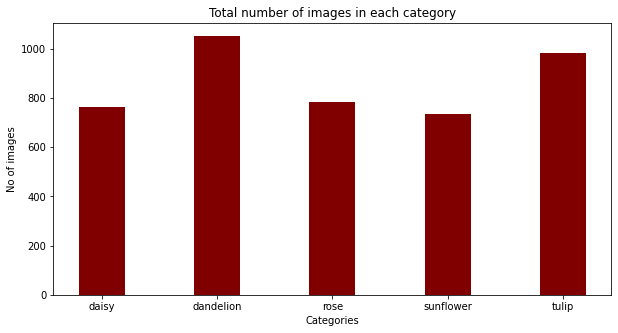

In [ ]:
dir = '/content/gdrive/MyDrive/flower/flowers'
classes = ['daisy','dandelion','rose','sunflower','tulip']
values = []
total_images = 0
for c in classes :
  flower_path = os.path.join(dir,c)
  count = 0
  for path in os.listdir(flower_path):
      count+=1
  values.append(count)
  total_images +=count
print(values)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Categories")
plt.ylabel("No of images")
plt.title("Total number of images in each category")
plt.show()

We need to convert the images into nd-arrays .The next step is to combine all the image numpy arrays with their labels, into a common file, so as to make the training and testing process easier."

In [ ]:
def prepare_dataset():
    record = []
    for c in classes :
        path = os.path.join(dir,c)
        label = classes.index(c)

        for img_name in os.listdir(path):
            image_path = os.path.join(path,img_name)
            image = cv2.imread(image_path)

            try :
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image,(224,224))

                image = np.array(image,dtype=np.float32)
                record.append([image,label])

            except Exception as e :
                pass

    pik = open('data.pickle','wb')
    pickle.dump(record,pik)
    pik.close()

In [ ]:
prepare_dataset()

Normalize the image arrays to prepare it for training.

In [ ]:
def load_dataset():
    pick = open('data.pickle','rb')
    data = pickle.load(pick)
    pick.close()

    np.random.shuffle(data)

    feature = []
    labels = []

    for img,label in data :
        feature.append(img)
        labels.append(label)

    feature = np.array(feature,dtype=np.float32)
    labels = np.array(labels)

    feature = feature/255.0

    return [feature,labels]

## **Step 3 : Model Preparation, Training and Testing**


1.   Split the data into training and testing samples.
2.   Reviewing the training data.
3.   Preparing convolutional and pooling layers in the model.
4.   Precautionary steps to avoid overfitting.
5.   Training the model.
6.   Saving the model in google drive.



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using sklearn's **train_test_split** to divide the data into training and testing samples.

In [ ]:
(feature,labels) = load_dataset()
X_train, X_test, Y_train, Y_test = train_test_split(feature,labels,test_size = 0.1,random_state=42)
classes = ['daisy','dandelion','rose','sunflower','tulip']

Viewing some of the data samples from the training split, to ensure proper working without errors.

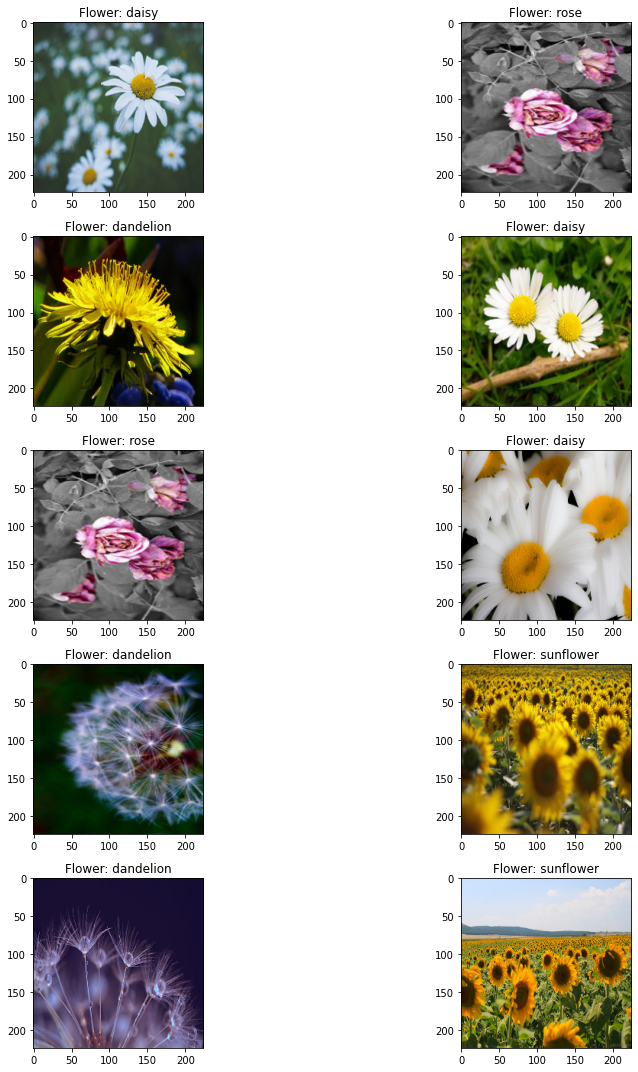

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(X_test))
        ax[i,j].imshow(X_test[l])
        ax[i,j].set_title('Flower: '+classes[Y_test[l]])
        
plt.tight_layout()

Adding the input layer to the model, followed by layers of 2D convolutional neural netorks and max pooling. Finsihing with an output layer at the end after the dense layer.

In [ ]:
input_layer = tf.keras.layers.Input([224,224,3])

conv1 = tf.keras.layers.Conv2D(filters = 32,kernel_size=(5,5),padding='Same',activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3),padding='Same',activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv2)

conv3 = tf.keras.layers.Conv2D(filters = 96, kernel_size=(3,3),padding='Same',activation='relu')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv3)

conv4 = tf.keras.layers.Conv2D(filters = 96, kernel_size=(3,3),padding='Same',activation='relu')(pool3)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv4)

flt1 = tf.keras.layers.Flatten()(pool4)

dn1 = tf.keras.layers.Dense(512,activation='relu')(flt1)
output_layer = tf.keras.layers.Dense(5,activation='softmax')(dn1)

In [ ]:
model = tf.keras.Model(input_layer,output_layer)

Performing data augmentation to avoid model overfitting.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 96)        0     

In [ ]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Training the model on the training dataset, for 20 epochs and a batch_size of 100.

In [ ]:
batch_size = 100
epochs = 20

History = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
38/38 [==============================] - 452s 12s/step - loss: 1.5293 - accuracy: 0.3522 - val_loss: 1.2652 - val_accuracy: 0.5046
Epoch 2/20
38/38 [==============================] - 448s 12s/step - loss: 1.1654 - accuracy: 0.5181 - val_loss: 1.0895 - val_accuracy: 0.5347
Epoch 3/20
38/38 [==============================] - 449s 12s/step - loss: 1.0473 - accuracy: 0.5834 - val_loss: 1.0096 - val_accuracy: 0.5972
Epoch 4/20
38/38 [==============================] - 449s 12s/step - loss: 0.9832 - accuracy: 0.6180 - val_loss: 0.9825 - val_accuracy: 0.6065
Epoch 5/20
38/38 [==============================] - 449s 12s/step - loss: 0.9134 - accuracy: 0.6473 - val_loss: 0.9468 - val_accuracy: 0.6227
Epoch 6/20
38/38 [==============================] - 450s 12s/step - loss: 0.8840 - accuracy: 0.6555 - val_loss: 0.9396 - val_accuracy: 0.6134
Epoch 7/20
38/38 [==============================] - 450s 12s/step - loss: 0.8437 - accuracy: 0.6732 - val_loss: 0.8450 - val_accuracy: 0.6829
Epoch 

In [ ]:
model.save('flower_pred_updated.h5')

## **Step 4 : Model Evaluation**


1.   Evaluating the model's accuracy on the testing dataset.
2.   Viewing the model's results for some random data from the testing split.
3.   Checking model's performance on a random image from the internet.
4.   Calculating accuracy, precision, recall, f1 score and plotting the confusion matrix for the model. 




In [ ]:
model = tf.keras.models.load_model('flower_pred_updated.h5')

model.evaluate(X_test,Y_test,verbose = 1)

14/14 [==============================] - 13s 935ms/step - loss: 0.6393 - accuracy: 0.7801


[0.6393435597419739, 0.7800925970077515]

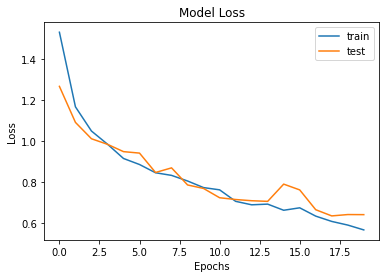

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

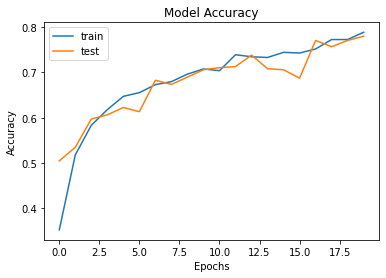

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Making predictions on the test dataset and plotting the results to verify.

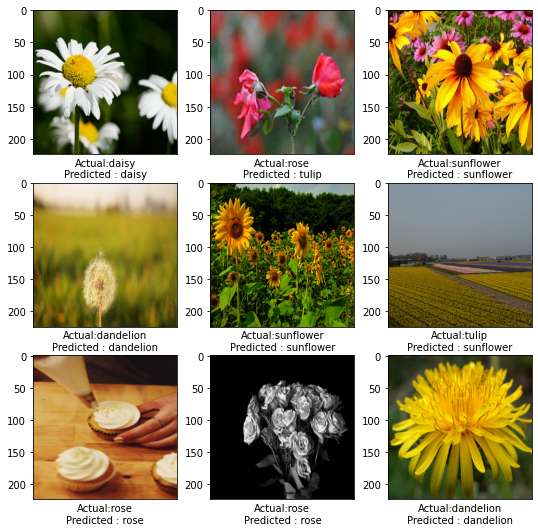

In [ ]:
predictions = model.predict(X_test)
plt.figure(figsize=(9,9))

for i in range(9) :
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.xlabel('Actual:'+classes[Y_test[i]]+'\n'+'Predicted : '+classes[np.argmax(predictions[i])])
    plt.xticks([])
plt.show()

Testing the model's accuracy on a random image from the internet.

[[8.4386226e-03 6.4155152e-05 9.6796137e-01 8.0971082e-04 2.2726178e-02]]
0.008438623
2


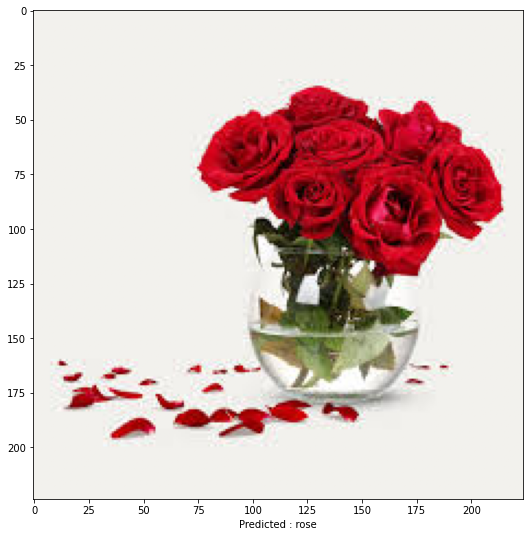

In [ ]:
pred_image_path = '/content/gdrive/MyDrive/flower/images.png'
pred_image = cv2.imread(pred_image_path)
pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
pred_image = cv2.resize(pred_image,(224,224))

# print(pred_image)

pred_image = np.array(pred_image,dtype=np.float32)

feat = []
lab = []
feat.append(pred_image)
lab.append('rose')

feat = np.array(feat,dtype=np.float32)
lab = np.array(lab)
feat = feat/255.0
preds = model.predict(feat)
print(preds)
plt.figure(figsize=(9,9))
plt.imshow(feat[0])
plt.xlabel('Predicted : '+classes[np.argmax(preds)])
print(np.argmax(preds))




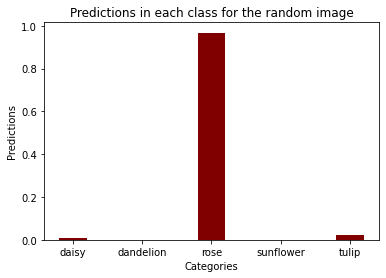

In [ ]:
values = []
for i in preds[0] :
  values.append(float(i))
plt.bar(classes,values, color ='maroon', width = 0.4)
 
plt.xlabel("Categories")
plt.ylabel("Predictions")
plt.title("Predictions in each class for the random image")
plt.show()

In [ ]:
## Model Evaluation
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

In [ ]:
model = tf.keras.models.load_model('flower_pred_updated.h5')

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [ ]:
predictions = model.predict(X_test)

obtained = []
truth = []
for i in range(len(predictions)) : 
    obtained.append(classes[np.argmax(predictions[i])])
    truth.append(classes[Y_test[i]])


cm = confusion_matrix(truth,obtained)


Plotting the confusion matrix based on the results obtained from evaluating the test dataset.

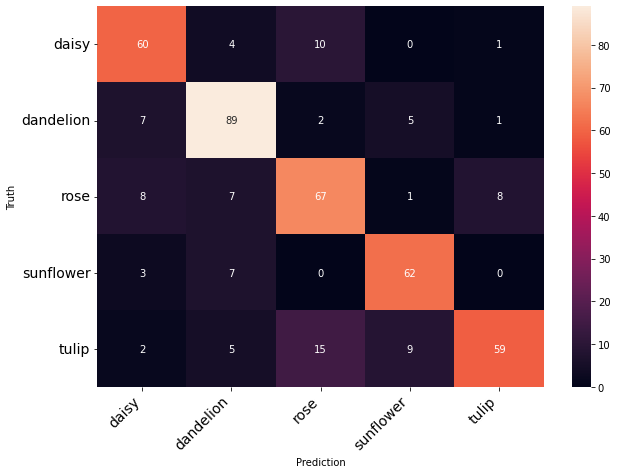

In [ ]:
print_confusion_matrix(cm,['daisy','dandelion','rose','sunflower','tulip'])

Classification report providing with the precision, recall and f1-score for the model.

In [ ]:
print(classification_report(truth,obtained))

              precision    recall  f1-score   support

       daisy       0.75      0.80      0.77        75
   dandelion       0.79      0.86      0.82       104
        rose       0.71      0.74      0.72        91
   sunflower       0.81      0.86      0.83        72
       tulip       0.86      0.66      0.74        90

    accuracy                           0.78       432
   macro avg       0.78      0.78      0.78       432
weighted avg       0.78      0.78      0.78       432

